# Task 2: Analysis of factors affecting Linear Regression

1. General Analysis 
<br>&nbsp;a. Distribution of estimated coefficients and residuals 
<br>&nbsp;&nbsp;(i) 1 covariate 
<br>&nbsp;&nbsp;(ii) 3 covariate 

2. Outliers 
<br>&nbsp;a. Number of Outliers
<br>&nbsp;b. Magnitude of Outliers
<br>&nbsp;c. Detecting Outliers
<br>&nbsp;&nbsp;(i) Overview - using influence plots
<br>&nbsp;&nbsp;(ii) Using y-residual graphs 
<br>&nbsp;&nbsp;(iii) Using fitted-vs-residuals plots 
<br>&nbsp;d. Effect of outliers on normalization of covariates

3. Multicollinearity
<br>&nbsp;a.Effect of coefficient estimation
<br>&nbsp;b.Using the Variance Inflation Factor 
<br>&nbsp;c.Handling multicollinearity 
<br>&nbsp;&nbsp;(i) eliminating highly correlated variable 
<br>&nbsp;&nbsp;(ii) using PCA to find uncorrelated covariates for regression 

In [89]:
import numpy as np
import pandas as pd
import math
import random 
from scipy import stats
from numpy.random import default_rng


# We will use matplotlib to plot figures
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set()

from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# For regression analysis we will use the statsmodels package
import statsmodels.formula.api as sm
import statsmodels.tools.eval_measures as sme 
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor


# For visual inspection of the regression models
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

In [90]:
#import helper function
%run helper_functions.py

<Figure size 432x288 with 0 Axes>

In [91]:
LINE_PARAMETERS = [7,8,9]
rng = default_rng()

# General Analysis

In [92]:
NUMBER_OF_SAMPLES = 100
SEED = 1028

### Distribution of estimated coefficients and residuals

### 1 covariate


OLS model parameters:
Intercept: -0.23714, Intercept SE: 0.21402
x1 coef: 7.01999, x1 coef SE: 0.03603

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 2.118, Root Mean Squared Error: 2.107


(-2.4424906541753446e-16, 2.117885281492146, 2.1072692483177025)

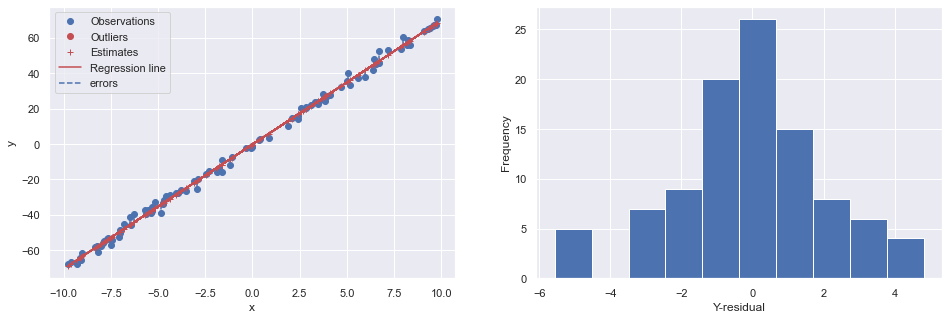

In [10]:
#generate data  
data = generate_data(1, [-10], [10], 0, 2, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 1, LINE_PARAMETERS)

#fit using OLS model
result = sm.ols(formula='y ~ x1', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#plot scatter and residuals graph 
plot_scatter_yresiduals(data)

#Model Evaluation
eval_ols_model(data)

**LHS: This graphs plots the actual and estimated data points for the observed and OLS data model. Based on the parameter values generated by the model, we note that the slope and intercept model very closely correspond with the parameters of the true model. The OLS model produced a slope value of 6.989 with a standard error of 0.0354. As the actual value of the slope parameter is 7, we note that the true value falls within the error margin of the slope parameter from the model. 
<br><br> RHS:By inspecting the histogram of the y-residuals, we observe that it follows a normal distribution with a mean roughly equal to 0 and a standard deviation roughly equal to 2. This is true to the noise variable injected to the model which also follows a normal distribution with a mean = 0 and standard deviation = 2.**

## 3 covariates

#### scale of covariates


OLS model parameters:
Intercept: -0.21973, Intercept SE: 0.21405
x1 coef: 7.6428, x1 coef SE: 0.73992
x2 coef: 7.99759, x2 coef SE: 0.00714
x3 coef: 8.99891, x3 coef SE: 0.00074

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 2.093, Root Mean Squared Error: 2.082


(-1.1880274541908874e-13, 2.092829816700484, 2.0823393756191315)

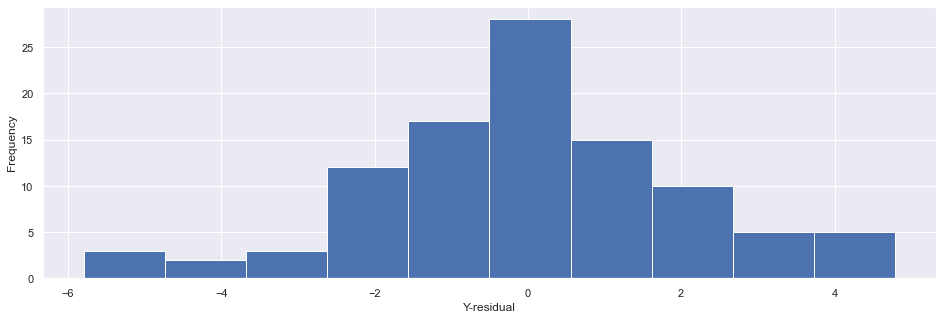

In [21]:
#generate data  
data = generate_data(3, [-.5, -50, -500], [.5, 50, 500], 0, 2, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 3, LINE_PARAMETERS)

#fit using OLS model
result = sm.ols(formula='y ~ x1 + x2 + x3', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#plot y-residuals
fig = plt.figure(figsize=(16,5))                                  
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')

#Model Evaluation
eval_ols_model(data)

**In this model, we observe the performance of an OLS model when the scales of the covariates vary and a negligible noise factor is injected to the true model. We note that although the parameter estimates deviate slightly from the true value, they closely model the true values with x1's coefficient having a higher standard deviation than those of the other variables. This can be explained as the scale of values for x1 are several orders of magnitude smaller than x2 and x3.**

# Outliers

**To study effects outliers on linear regression, a single covariate was used to allow for visual representation of the outliers in 2D graph**

In [22]:
NUMBER_OF_SAMPLES = 25

## Number of outliers

**In this section, we observe the effects of introducing a specific percentage of the datapoints as outliers. The maximum percentage of outliers being studied is 30% as with values higher than this, the model may not be a good candidate for linear regression. Here we define an outlier as a data point that deviates anywhere between 0 to 4 times the expected y-value of the true model. Also note that the scale factor for each outlier is chosen at random.  each iteration of a specific percentage of outliers is run 5 times to ensure results can be reproduced.**

In [23]:
perc_outliers = np.arange(1,31, 1) 

results_df = pd.DataFrame(columns=['%Outliers', 'Coefficient', 'Coefficient_SE', 'Intercept', 'Intercept_SE', 'RMSE'])

for val in perc_outliers:
    for i in range(0,10):
        #generate random data + add % of outliers 
        data = generate_data(1, [-10], [10], 2, 5, NUMBER_OF_SAMPLES)
        data['y'] = calculate_y(data, 1, LINE_PARAMETERS)
        data = add_outliers(data, val, 0, 4)
        #fit using an ols model 
        result = sm.ols(formula='y ~ x1', data=data).fit()
        #calculate estimated and residual values,rmse
        data['y_est'] = calculate_y_est(data, result)
        data['residuals'] = data['y_est'] - data['y']
        rmse = np.sqrt(metrics.mean_squared_error(data.y, data.y_est))

        #add result to df 
        new_result = {'%Outliers': round(val), 'Coefficient' : result.params[1], 'Coefficient_SE': result.bse[1], 'Intercept': result.params[0], 
                              'Intercept_SE': result.params[0], 'RMSE': rmse}
        results_df = results_df.append(new_result, ignore_index = True)
    
#calculate average across all iterations
results_df = results_df.groupby(['%Outliers']).mean().reset_index()
#calculate error in coefficient estimation
results_df['Coefficient_Error%'] = (abs(results_df['Coefficient']-LINE_PARAMETERS[0])/LINE_PARAMETERS[0])*100

results_df.head()

,%Outliers,Coefficient,Coefficient_SE,Intercept,Intercept_SE,RMSE,Coefficient_Error%
0,1.0,6.919864,0.196146,1.840655,1.840655,5.085422,1.144799
1,2.0,7.519139,0.470835,2.255435,2.255435,12.831295,7.416272
2,3.0,7.250780,0.359681,2.507917,2.507917,9.654414,3.582575
3,4.0,7.380760,0.442134,2.236403,2.236403,12.081334,5.439422
4,5.0,7.206027,0.409170,2.365276,2.365276,10.678372,2.943243


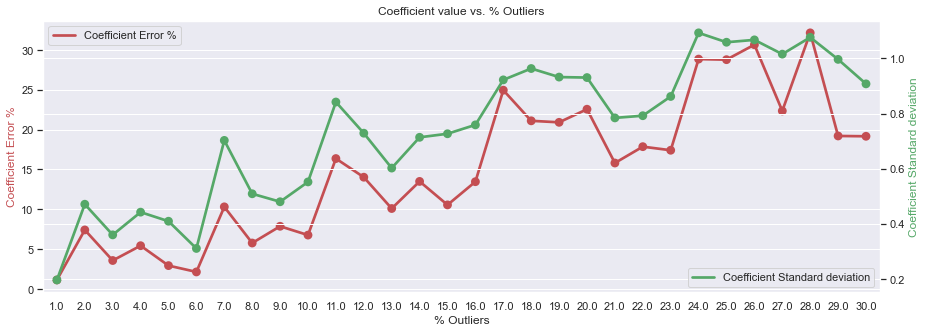

In [63]:
sns.set(rc = {'figure.figsize':(15,5)})

fig, ax1 = plt.subplots() 
ax1.set_title('Coefficient value vs. % Outliers')

ax2 = ax1.twinx() 

ax1 = sns.pointplot(x="%Outliers", y="Coefficient_Error%", data=results_df, color = "r", ax = ax1)
ax1.set_xlabel('% Outliers')
ax1.set_ylabel('Coefficient Error %', color='r')
ax1.legend(loc='upper left', labels=['Coefficient Error %'])

ax2 = sns.pointplot(x="%Outliers", y="Coefficient_SE", data=results_df, color = 'g', ax = ax2)
ax2.set_ylabel('Coefficient Standard deviation', color='g')

ax2.legend(loc='lower right', labels=['Coefficient Standard deviation'])

plt.show(); 

Text(0.5, 1.0, 'RMSE vs. % Outliers')

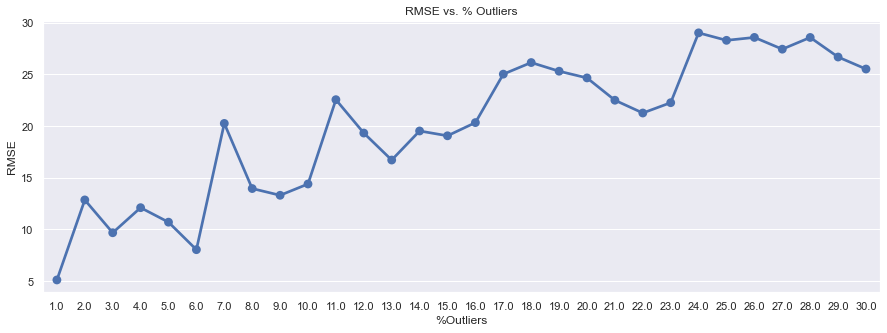

In [25]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
#tips = sns.load_dataset("tips")
ax = sns.pointplot(x="%Outliers", y="RMSE", data=results_df)
ax.set_title('RMSE vs. % Outliers')

We observe that there is a positive somewhat linear relationship between the percentage of outliers in a dataset and the error in the model's covariate coefficient estimation and standard deviation and the model's RMSE. 

## Magnitude of outliers

In [65]:
max_scale_factor = np.arange(-2,4, 0.5)

results_df = pd.DataFrame(columns=['Outlier_Mag', 'Coefficient', 'Coefficient_SE', 'Intercept', 'Intercept_SE','RMSE'])


for val in max_scale_factor:
    for i in range(0,10):
        #generate random data + add % of outliers 
        data = generate_data(1, [-10], [10], 2, 5, NUMBER_OF_SAMPLES)
        data['y'] = calculate_y(data, 1, LINE_PARAMETERS)
        data = scale_datapoints(data, 10, val) #scale 10% of datapoint
        #fit using an ols model 
        result = sm.ols(formula='y ~ x1', data=data).fit()
        #calculate estimated and residual values,rmse
        data['y_est'] = calculate_y_est(data, result)
        data['residuals'] = data['y_est'] - data['y']
        rmse = np.sqrt(metrics.mean_squared_error(data.y, data.y_est))

        #add result to df 
        new_result = {'Outlier_Mag': val, 'Coefficient' : result.params[1], 'Coefficient_SE': result.bse[1], 'Intercept': result.params[0], 
                              'Intercept_SE': result.params[0], 'RMSE': rmse}
        results_df = results_df.append(new_result, ignore_index = True)
    
#calculate average across all iterations
results_df = results_df.groupby(['Outlier_Mag']).mean().reset_index()
#calculate error in coefficient estimation
results_df['Coefficient_Error%'] = (abs(results_df['Coefficient']-LINE_PARAMETERS[0])/LINE_PARAMETERS[0])*100

results_df.head()

,Outlier_Mag,Coefficient,Coefficient_SE,Intercept,Intercept_SE,RMSE,Coefficient_Error%
0,-2.0,4.347741,1.387656,-3.355912,-3.355912,36.660555,37.889413
1,-1.5,5.075887,1.083831,3.038220,3.038220,30.343133,27.487324
2,-1.0,5.357578,0.873143,3.857724,3.857724,24.449139,23.463171
3,-0.5,5.757086,0.722212,1.784813,1.784813,19.505552,17.755909
4,0.0,5.922466,0.572478,0.554648,0.554648,15.012807,15.393336


In [67]:
results_df.tail()

,Outlier_Mag,Coefficient,Coefficient_SE,Intercept,Intercept_SE,RMSE,Coefficient_Error%
7,1.5,7.361632,0.303196,0.451562,0.451562,8.193892,5.166172
8,2.0,7.765223,0.467905,2.540991,2.540991,12.171226,10.931750
9,2.5,8.367449,0.723109,1.216374,1.216374,19.010780,19.534986
10,3.0,8.541647,0.907752,-1.398983,-1.398983,23.999448,22.023526
11,3.5,8.780974,1.104873,3.939146,3.939146,28.578762,25.442482


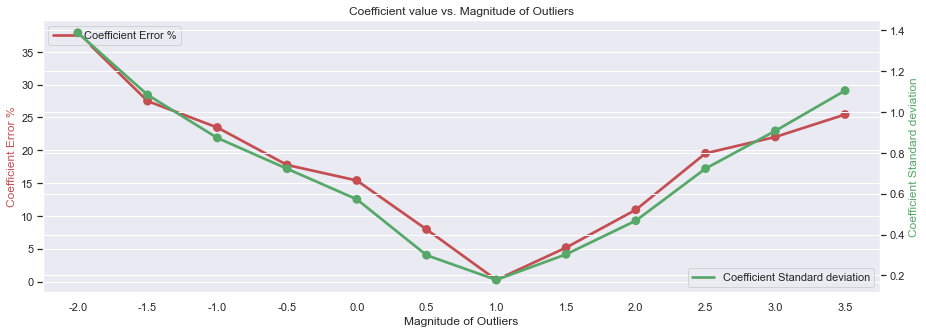

In [71]:
sns.set(rc = {'figure.figsize':(15,5)})

fig, ax1 = plt.subplots() 
ax1.set_title('Coefficient value vs. Magnitude of Outliers')

ax2 = ax1.twinx() 

ax1 = sns.pointplot(x="Outlier_Mag", y="Coefficient_Error%", data=results_df, color = "r", ax = ax1)
ax1.set_xlabel('Magnitude of Outliers')
ax1.set_ylabel('Coefficient Error %', color='r')
ax1.legend(loc='upper left', labels=['Coefficient Error %'])

ax2 = sns.pointplot(x="Outlier_Mag", y="Coefficient_SE", data=results_df, color = 'g', ax = ax2)
ax2.set_ylabel('Coefficient Standard deviation', color='g')

ax2.legend(loc='lower right', labels=['Coefficient Standard deviation'])

plt.show(); 

Text(0.5, 1.0, 'RMSE vs.  Magnitude of Outliers')

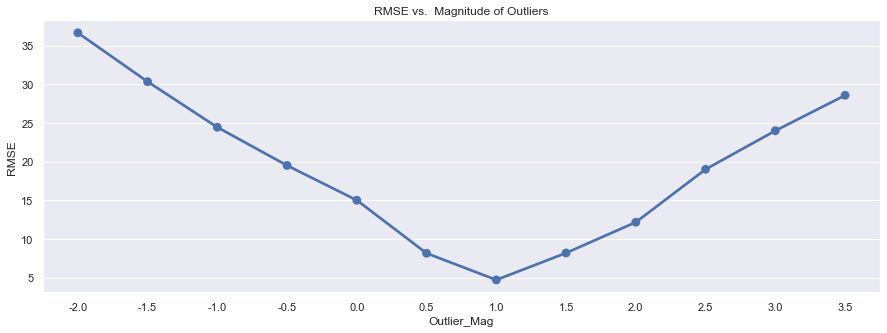

In [73]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
#tips = sns.load_dataset("tips")
ax = sns.pointplot(x="Outlier_Mag", y="RMSE", data=results_df)
ax.set_title('RMSE vs.  Magnitude of Outliers')

Just as with above, the magnitude of outliers also negatively affects model parameter estimation. However here we observe that there's symmetry when the magnitude of outliers = 1, that is when there's no outliers in the dataset, that's when the model performs well. This can also be observed by noting that the same point represents the value at which RMSE is the lowest. 


## Detecting Outliers

**In this section, various tools to detect outliers in a data model are studied. Furthermore, a methods to find outliers in the covariate and noise variables are also discussed.** 

In [77]:
# fix the generator to a seed
SEED = 28
NUMBER_OF_SAMPLES = 50

**Baseline Model without outliers**


OLS model parameters:
Intercept: -0.02042, Intercept SE: 0.2911
x1 coef: 7.01128, x1 coef SE: 0.049

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 1.982, Root Mean Squared Error: 1.962


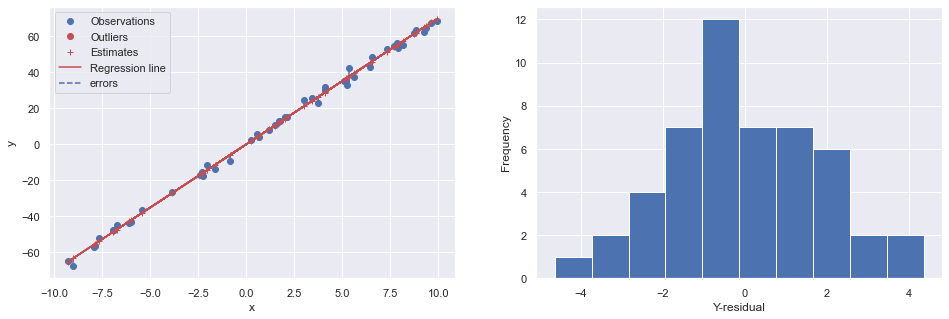

In [78]:
#generate data  
data = generate_data(1, [-10], [10], 0, 2, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 1, LINE_PARAMETERS)

#fit using OLS model
result = sm.ols(formula='y ~ x1', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#plot scatter and residuals graph 
plot_scatter_yresiduals(data)

#Model Evaluation
mean, sd, RMSE = eval_ols_model(data)

**Model with outliers**


OLS model parameters:
Intercept: -0.50859, Intercept SE: 4.21073
x1 coef: 8.99364, x1 coef SE: 0.70884

Model Evaluation: 
Y-residual Mean: 0.0, Y-residual SD: 28.67, Root Mean Squared Error: 28.382


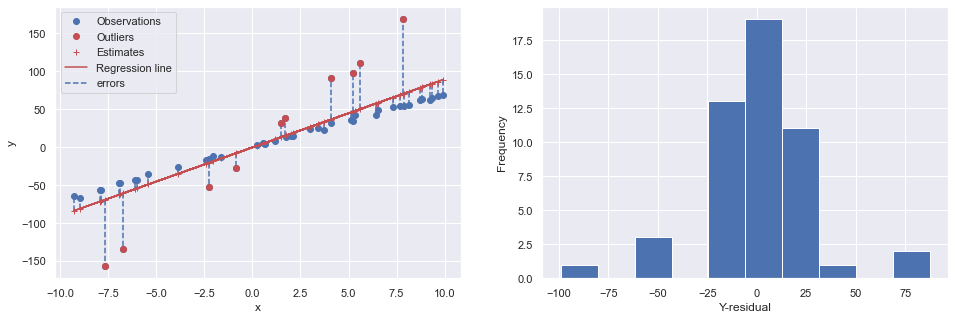

In [79]:
#data_out = scale_datapoints_variable(data, 20, 1, 4)
data_out = scale_datapoints(data.copy(), 20, 3) # use this to ensure results can be reproduced 

#fit using OLS model
result_out = sm.ols(formula='y ~ x1', data=data_out).fit()
print_OLS_result(result_out)

#calculate estimated and residual values
data_out['y_est'] = calculate_y_est(data_out, result_out)
data_out['residuals'] = data_out['y_est'] - data_out['y']

#plot scatter and residuals graph 
plot_scatter_yresiduals(data_out)

#Model Evaluation
mean_o, sd_o, RMSE_o = eval_ols_model(data_out)

### Using Influence plots

**The leverage vs. Normalized residuals squared plot can be used to identify potentials outliers in a data model. The top right quadrant of the graph identifies points with high leverage and high residuals.**

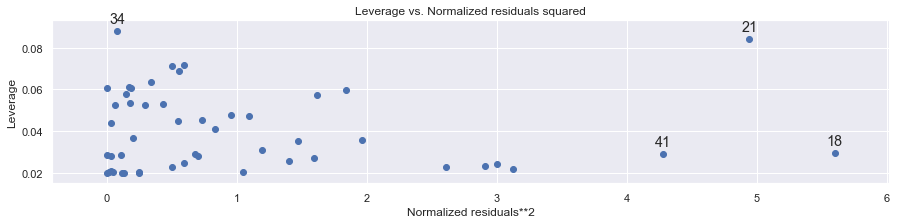

In [80]:
fig, ax = plt.subplots(figsize=(15,3))
fig = plot_leverage_resid2(result, ax=ax)

**The influence plot below can also be used to identify outliers. Here, the leverage of each datapoint is plotted against a different statistic, the studentized residuals. Just as the previous, we focus on finding points with high leverage and high residuals.**

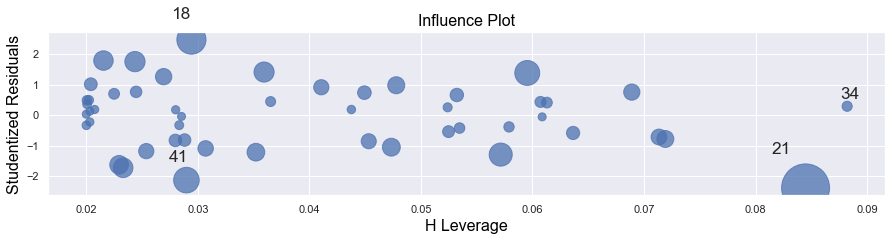

In [81]:
fig, ax = plt.subplots(figsize=(15,3))
fig = influence_plot(result, ax=ax)

### Using Y-residual Plots 

**The Y-residual plots can be examined to find any outliers.**

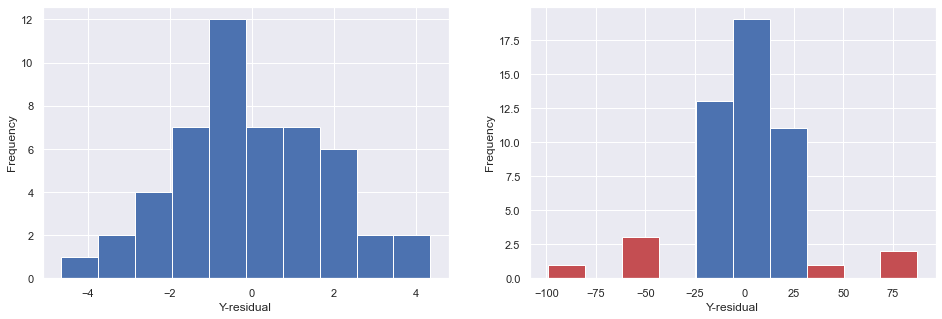

In [87]:
fig = plt.figure(figsize=(16,5))  
ax1 = fig.add_subplot(121) 
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')

ax2 = fig.add_subplot(122) 
n, bins, patches = plt.hist(data_out.residuals)
patches[0].set_fc('r')
patches[1].set_fc('r')
patches[2].set_fc('r')
#patches[4].set_fc('r')
#patches[6].set_fc('r')
patches[7].set_fc('r')
patches[9].set_fc('r')

plt.xlabel('Y-residual')
plt.ylabel('Frequency')
None

### Using Fitted-vs-Residual  Plots 

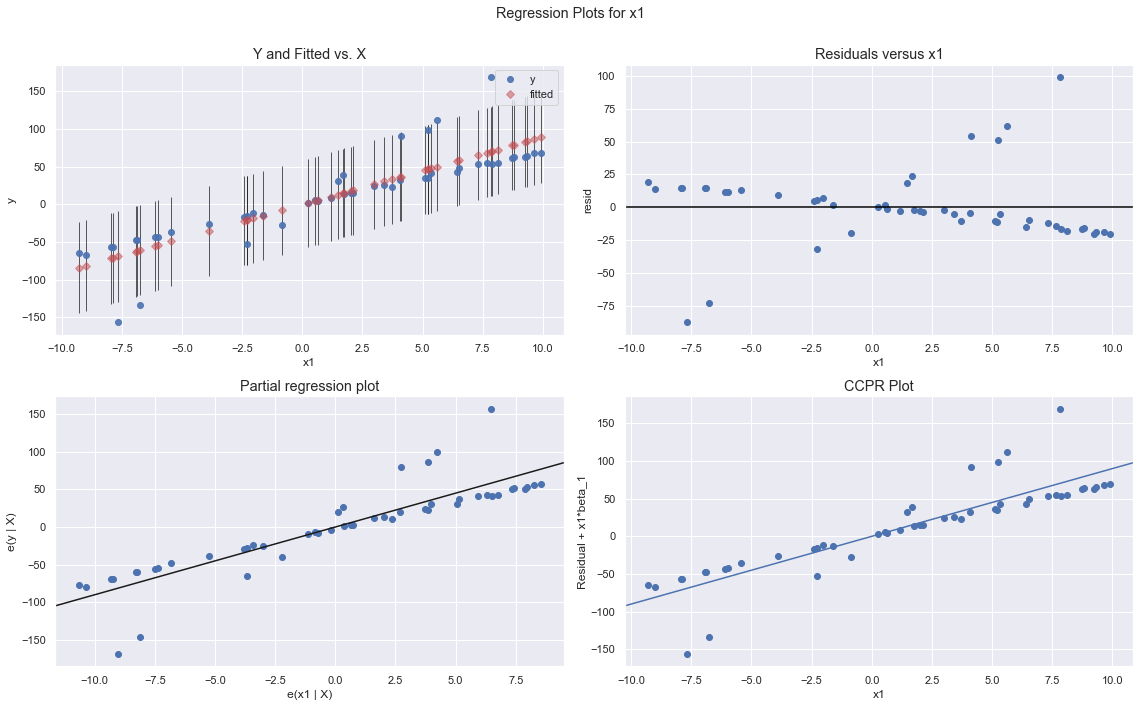

In [198]:
fig = plt.figure(figsize=(16,10))
fig = plot_regress_exog(result_out, "x1", fig = fig)

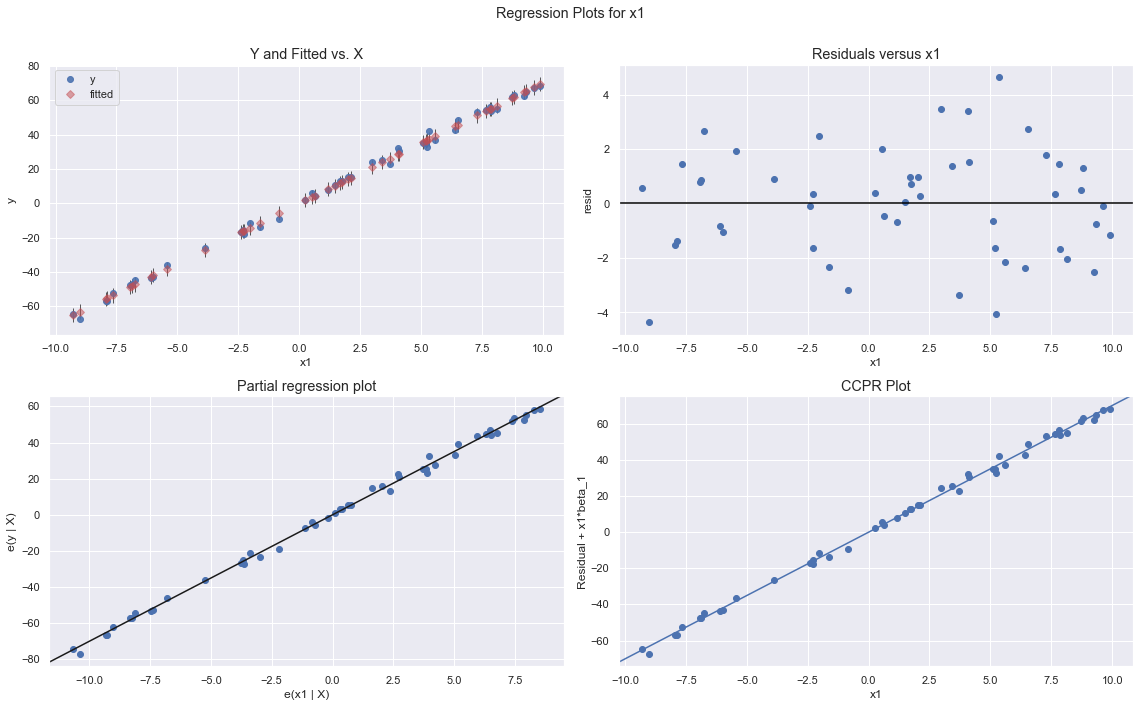

In [199]:
fig = plt.figure(figsize=(16,10))
fig = plot_regress_exog(result, "x1", fig = fig)

**By removing each of the identified outliers, we note that there is an improvement of the slope parameter estimation as well as the model's RMSE**

In [200]:
stats_df = pd.DataFrame(columns = ['a_est', 'a_est_sd', 'rmse']) 
new_result = {'a_est': result_out.params[1], 'a_est_sd': result_out.bse[1], 'rmse': get_RMSE(data_out.y_est, data_out.y)}
stats_df = stats_df.append(new_result, ignore_index = True)

outliers = data_out[data_out.point=='Outlier'].index 

for outlier in outliers:
    data_out = data_out.drop(outlier)
    model = sm.ols(formula='y ~ x1', data=data_out).fit()
    
    #calculate estimated and residual values
    data_out['y_est'] = calculate_y_est(data_out, model)
    data_out['residuals'] = data_out['y_est'] - data_out['y']
    
    new_result = {'a_est': model.params[1], 'a_est_sd': model.bse[1], 'rmse': get_RMSE(data_out.y_est, data_out.y)}
    stats_df = stats_df.append(new_result, ignore_index = True)
    
#stats_df

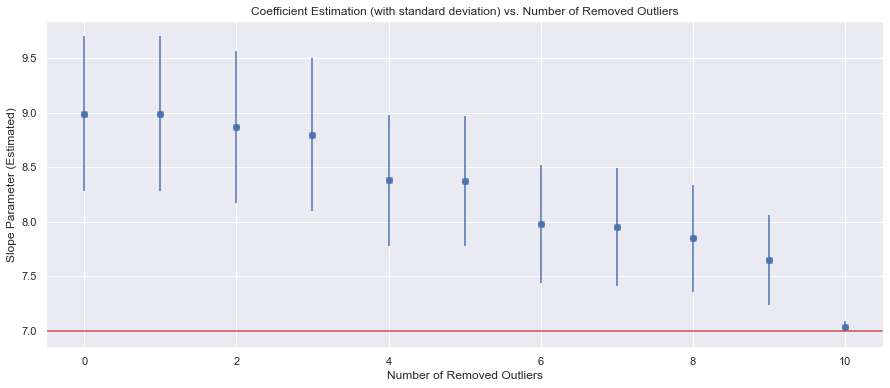

In [201]:
fig = plt.figure(figsize=(15,6))
plt.scatter(stats_df.index, stats_df.a_est)
plt.errorbar(stats_df.index, stats_df.a_est, yerr=stats_df.a_est_sd, fmt="x")
plt.axhline(y=LINE_PARAMETERS[0], color='r', linestyle='-')
plt.title('Coefficient Estimation (with standard deviation) vs. Number of Removed Outliers')
plt.xlabel('Number of Removed Outliers')
plt.ylabel('Slope Parameter (Estimated)')

None

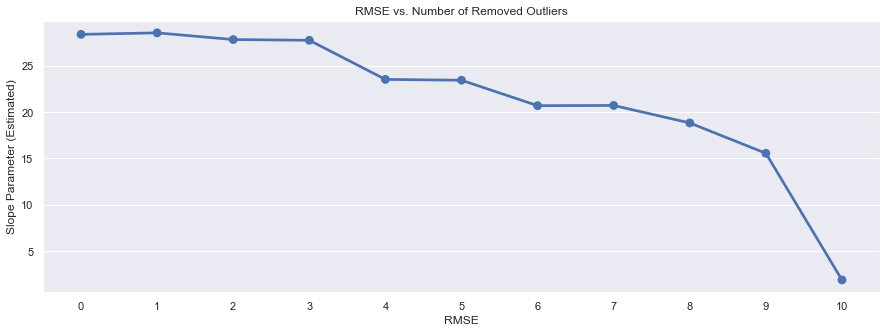

In [202]:
sns.set_theme(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,5)})
ax = sns.pointplot(x="index", y="rmse", data=stats_df.reset_index())
ax.set_title('RMSE vs. Number of Removed Outliers')
plt.xlabel('RMSE')
plt.ylabel('Slope Parameter (Estimated)')
None

## Effect of outliers on normalization of covariates


OLS model parameters:
Intercept: 26.02994, Intercept SE: 34.01226
x1 coef: 9.78238, x1 coef SE: 1.08578
x2 coef: 0.00526, x2 coef SE: 0.2183
x3 coef: -0.35436, x3 coef SE: 0.433

Model Evaluation: 
Y-residual Mean: 0.0, Y-residual SD: 42.958, Root Mean Squared Error: 42.527


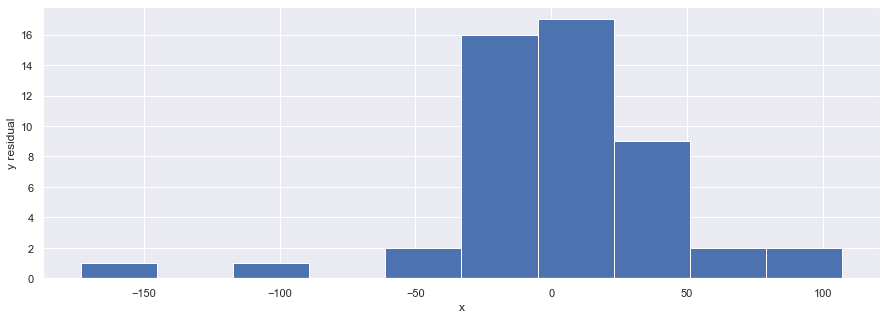

In [203]:
#generate data  
data = generate_data(3, [-10, -50, 50], [10, 50, 100], 0, 10, NUMBER_OF_SAMPLES, SEED)
data['y'] = calculate_y(data, 1, LINE_PARAMETERS)

data = scale_datapoints(data.copy(), 20, 4) # use this to ensure results can be reproduced 

#fit using OLS model
result = sm.ols(formula='y ~ x1 + x2 + x3', data=data).fit()
print_OLS_result(result)

#calculate estimated and residual values
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

#Model Evaluation
mean, sd, RMSE = eval_ols_model(data)

#plot y-residuals 
sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data.residuals)
plt.xlabel('x')
plt.ylabel('y residual')
None



OLS model parameters:
Intercept: 0.14046, Intercept SE: 0.20145
x1 coef: 7.97352, x1 coef SE: 0.73456
x2 coef: -0.06931, x2 coef SE: 0.13102
x3 coef: -0.17399, x3 coef SE: 0.25629

Model Evaluation: 
Y-residual Mean: -0.0, Y-residual SD: 0.276, Root Mean Squared Error: 0.274


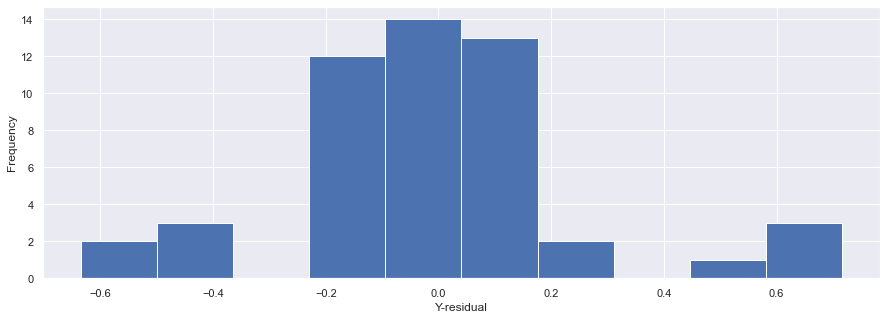

In [204]:
data_out = data.copy()

transformer = Normalizer()
data_trans = transformer.fit_transform(data_out[['x1','x2','x3', 'y']]) 
data_scaled = pd.DataFrame({'x1': data_trans.T[0], 'x2': data_trans.T[1], 'x3' : data_trans.T[2], 'y':data_trans.T[3] })

#fit using OLS model
result_out = sm.ols(formula='y ~ x1 + x2 + x3', data=data_scaled).fit()
print_OLS_result(result_out)

#calculate estimated and residual values
data_scaled['y_est'] = calculate_y_est(data_scaled, result_out)
data_scaled['residuals'] = data_scaled['y_est'] - data_scaled['y']


#Model Evaluation
mean, sd, RMSE = eval_ols_model(data_scaled)

#plot y-residuals 
sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data_scaled.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')
None

In [205]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     27.50
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           2.44e-10
Time:                        20:42:07   Log-Likelihood:                -258.45
No. Observations:                  50   AIC:                             524.9
Df Residuals:                      46   BIC:                             532.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.0299     34.012      0.765      0.448     -42.433      94.493
x1             9.7824      1.086      9.010      0.000       7.597      11.968
x2             0.0053      0.218      0.024      0.981      -0.434       0.445
x3            -0.3544      0.433     -0.818      0.417      -1.226       0.517
==============================================================================
Omnibus:                       21.324   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.658
Skew:                           1.034   Prob(JB):                     4.98e-13
Kurtosis:                       7.787   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Multicollinearity

## Effect of coefficient estimation

In [93]:
# build model with 3 independent and 3 correlated variables 

In [94]:
#generate data
data = generate_data(4, [-10,-10,-10, -10],  [10, 10,10,10], 0, 10, 500, 1023)
data['x4'] = data['x4'] + data['x3'] + data['x2'] # depends on x4, x3, x2
data['x5'] = data['x2']*(3) + data['x3']*(-2) # depends on x2, x3
data['x6'] = data['x4'] + data['x5'] # depends on x2,x3,x4,x5

LINE_PARAMETERS = [3,4,5,6, 7, 8]
data['y'] = calculate_y(data, 5, LINE_PARAMETERS )
#fit using OLS model
result = sm.ols(formula='y ~ x1 + x2 + x3 + x4 + x5 + x6', data=data).fit()
result.summary()
#print_OLS_result(result)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.425e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:01:21   Log-Likelihood:                -1845.5
No. Observations:                 500   AIC:                             3701.
Df Residuals:                     495   BIC:                             3722.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2312      0.439      0.526      0.599      -0.632       1.095
x1             3.0470      0.075     40.536      0.000       2.899       3.195
x2             4.0729      0.082     49.455      0.000       3.911       4.235
x3             4.8053      0.111     43.239      0.000       4.587       5.024
x4             1.7184      0.055     31.041      0.000       1.610       1.827
x5             2.6082      0.032     81.188      0.000       2.545       2.671
x6             4.3266      0.027    162.506      0.000       4.274       4.379
==============================================================================
Omnibus:                        4.204   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                3.493
Skew:                           0.109   Prob(JB):                        0.174
Kurtosis:                       2.653   Cond. No.                     3.66e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.81e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [95]:
data['x6'] = data['x4']*2 + data['x5']*-1.8 # depends on x2,x3,x4,x5

LINE_PARAMETERS = [3,4,5,6, 7, 8]
data['y'] = calculate_y(data, 5, LINE_PARAMETERS )
#fit using OLS model
result = sm.ols(formula='y ~ x1 + x2 + x3 + x4 + x5 + x6', data=data).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.773e+05
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:01:23   Log-Likelihood:                -1845.5
No. Observations:                 500   AIC:                             3701.
Df Residuals:                     495   BIC:                             3722.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2312      0.439      0.526      0.599      -0.632       1.095
x1             6.0470      0.075     80.448      0.000       5.899       6.195
x2            10.0814      0.071    142.219      0.000       9.942      10.221
x3             8.4663      0.119     71.270      0.000       8.233       8.700
x4            11.9934      0.039    307.145      0.000      11.917      12.070
x5            13.3117      0.033    405.981      0.000      13.247      13.376
x6             0.0258      0.022      1.183      0.237      -0.017       0.069
==============================================================================
Omnibus:                        4.204   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                3.493
Skew:                           0.109   Prob(JB):                        0.174
Kurtosis:                       2.653   Cond. No.                     5.26e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.53e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

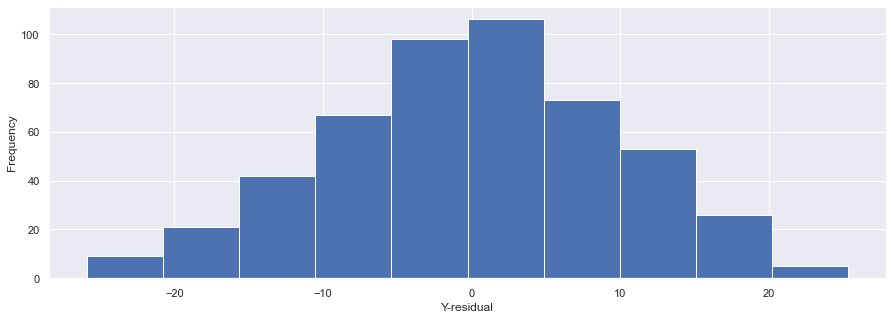

In [96]:
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')

None

## Using the Varaince Inflation Factor 

In [97]:
calculate_vif(data[['x1', 'x2',  'x3']]) # expected

,variables,VIF
0,x1,1.011815
1,x2,1.011702
2,x3,1.000293


In [98]:
calculate_vif(data[['x1', 'x2',  'x3', 'x4']]) # some multicollinearity, within limits 

,variables,VIF
0,x1,1.012717
1,x2,2.152754
2,x3,2.262910
3,x4,3.421330


In [99]:
calculate_vif(data[['x1', 'x2',  'x3', 'x4', 'x5']]) # expected as x5 is a linear combination of x2, x3

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,x1,1.012717
1,x2,inf
2,x3,inf
3,x4,3.421330
4,x5,inf


In [100]:
calculate_vif(data[['x1', 'x2',  'x3', 'x4', 'x5', 'x6']]) # only x1 is truly independent 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,x1,1.012717
1,x2,inf
2,x3,inf
3,x4,inf
4,x5,inf
5,x6,inf


## Handling multicollinearity 

### Eliminating highly correlated variable 

In [101]:
result = sm.ols(formula='y ~ x1 + x2 + x3', data=data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4989.
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:01:29   Log-Likelihood:                -2802.5
No. Observations:                 500   AIC:                             5613.
Df Residuals:                     496   BIC:                             5630.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2105      2.977      0.071      0.944      -5.639       6.060
x1             5.7123      0.509     11.223      0.000       4.712       6.712
x2            61.9623      0.519    119.417      0.000      60.943      62.982
x3            -5.4340      0.512    -10.616      0.000      -6.440      -4.428
==============================================================================
Omnibus:                      104.625   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.340
Skew:                          -0.040   Prob(JB):                     2.32e-05
Kurtosis:                       1.991   Cond. No.                         6.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Frequency')

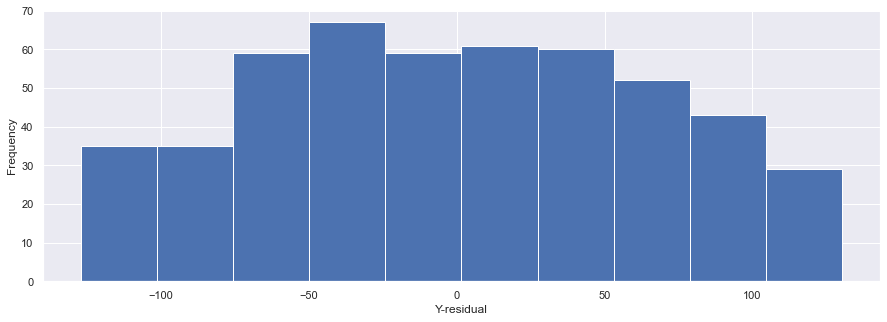

In [102]:
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')


In [103]:
result = sm.ols(formula='y ~ x1 + x2 + x3 + x4', data=data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.773e+05
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:01:31   Log-Likelihood:                -1845.5
No. Observations:                 500   AIC:                             3701.
Df Residuals:                     495   BIC:                             3722.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2312      0.439      0.526      0.599      -0.632       1.095
x1             6.0470      0.075     80.448      0.000       5.899       6.195
x2            49.8774      0.111    447.474      0.000      49.658      50.096
x3           -18.0643      0.113   -159.218      0.000     -18.287     -17.841
x4            12.0450      0.081    149.229      0.000      11.886      12.204
==============================================================================
Omnibus:                        4.204   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                3.493
Skew:                           0.109   Prob(JB):                        0.174
Kurtosis:                       2.653   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Frequency')

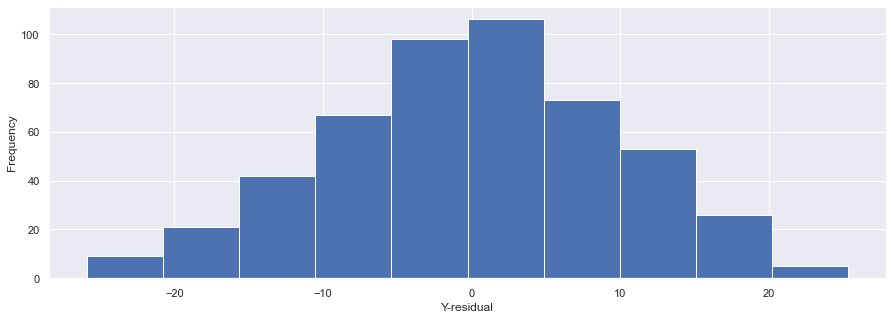

In [104]:
data['y_est'] = calculate_y_est(data, result)
data['residuals'] = data['y_est'] - data['y']

sns.set(rc = {'figure.figsize':(15,5)})
residuals_hist = plt.hist(data.residuals)
plt.xlabel('Y-residual')
plt.ylabel('Frequency')


### using PCA to find uncorrelated covariates for regression

In [110]:
dep_var = data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6']]
num_var = dep_var.shape[1]

In [114]:
pca = PCA(n_components = num_var)
pca_data = pca.fit_transform(dep_var)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cum_var_explained = np.cumsum(percent_var_explained)

array([0.8879325 , 0.98056241, 0.99592216, 1.        , 1.        ,
       1.        ])

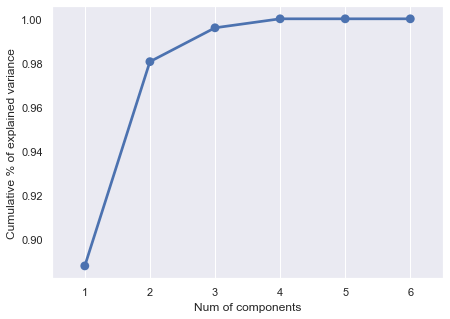

In [145]:
cum_var_explained_df = pd.DataFrame(data = cum_var_explained, columns = ['Cumulative % of explained variance'] ).reset_index().rename(columns = {'index': 'Num of components'})
cum_var_explained_df['Num of components'] = cum_var_explained_df['Num of components'] + 1
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.pointplot(x="Num of components", y="Cumulative % of explained variance", data=cum_var_explained_df)
plt.grid()
plt.show()

In [121]:
#transform into lower dimension
pca = PCA(n_components=3)
trans_data = pca.fit_transform(dep_var)
pca_var = pd.DataFrame(data = trans_data, columns = ['p_x1', 'p_x2', 'p_x3'])
pca_var['y'] = data.y
pca_var

,p_x1,p_x2,p_x3,y
0,32.812192,37.856501,1.555451,-601.557856
1,-20.936678,-27.474370,-2.881828,505.642274
2,17.757264,8.618378,9.409350,-93.156852
3,69.626463,-4.359777,-5.223683,438.918365
4,-0.587586,12.591087,3.160125,-291.207750
...,...,...,...,...
495,20.242654,-3.197073,-1.490462,171.652655
496,-8.298439,-21.206584,-3.772666,487.165457
497,-2.702527,-7.940233,2.380294,183.420395
498,34.525011,4.014767,8.515546,57.768320


In [146]:
calculate_vif(pca_var[['p_x1', 'p_x2',  'p_x3']])  

,variables,VIF
0,p_x1,1.0
1,p_x2,1.0
2,p_x3,1.0


In [122]:
#join back with original dataframe 
result = sm.ols(formula='y ~ p_x1 + p_x2 + p_x3', data=pca_var).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.913e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:14:44   Log-Likelihood:                -2238.1
No. Observations:                 500   AIC:                             4484.
Df Residuals:                     496   BIC:                             4501.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.4131      0.955     29.753      0.000      26.537      30.289
p_x1           4.7539      0.022    219.910      0.000       4.711       4.796
p_x2         -20.9441      0.067   -312.927      0.000     -21.076     -20.813
p_x3          -5.4493      0.164    -33.154      0.000      -5.772      -5.126
==============================================================================
Omnibus:                       19.255   Durbin-Watson:                   2.268
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.256
Skew:                           0.083   Prob(JB):                      0.00977
Kurtosis:                       2.354   Cond. No.                         44.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
#drop a variable to see if estimated coefficients change 
result = sm.ols(formula='y ~ p_x1 + p_x2', data=pca_var).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.279e+04
Date:                Sat, 01 Jan 2022   Prob (F-statistic):               0.00
Time:                        13:15:52   Log-Likelihood:                -2530.1
No. Observations:                 500   AIC:                             5066.
Df Residuals:                     497   BIC:                             5079.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.4131      1.711     16.607      0.000      25.052      31.775
p_x1           4.7539      0.039    122.748      0.000       4.678       4.830
p_x2         -20.9441      0.120   -174.668      0.000     -21.180     -20.708
==============================================================================
Omnibus:                       13.568   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.175
Skew:                          -0.044   Prob(JB):                       0.0277
Kurtosis:                       2.420   Cond. No.                         44.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Here we observe that by using PCA, 3 variables can capture upto 99% of the variability in the data. Therefore when putting this to a test and building the model with the first 3 component and then two component, we note that the estimated coefficients of x1 and x2 remain the same in both models confirming that using PCA we were able to sucessfully remove multicollinearity**